# Algoritmo Multinomial Naive Bayes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
import joblib
from sklearn.metrics import precision_score, make_scorer
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2

## Creación del modelo

Lo primero que hacemos es cargar los datasets que fueron creados en el notebook de preprocesamiento:

In [2]:
datos_train = pd.read_csv('train_Data.csv')
datos_test = pd.read_csv('test_Data.csv')
datos_train = datos_train.drop(["Unnamed: 0"], axis = 1)
datos_test = datos_test.drop(["Unnamed: 0"], axis = 1)
datos_train.sample(5)
datos_test.sample(5)

,problems_described,tokenized_abstracts,non_tokenized_abstracts,non_tokenized_entities,tokenized_entities
1974,3,"['attenu', 'neuropatholog', 'nilvadipin', 'mid...",attenu neuropatholog nilvadipin middl cerebr a...,nilvadipin cerebr arteri rat nilvadipin calciu...,"['nilvadipin', 'cerebr', 'arteri', 'rat', 'nil..."
865,1,"['pseudocyst', 'auricl', 'report', 'world', 'l...",pseudocyst auricl report world literatur revie...,auricl auricl auricl ear men ear triangular fo...,"['auricl', 'auricl', 'auricl', 'ear', 'men', '..."
179,5,"['obstruct', 'mechan', 'heart', 'valv', 'prost...",obstruct mechan heart valv prosthes clinic asp...,heart valv valv thrombus pannus mitral aortic ...,"['heart', 'valv', 'valv', 'thrombus', 'pannus'..."
2306,4,"['transesophag', 'echocardiographi', 'diagnosi...",transesophag echocardiographi diagnosi left at...,left atrial man atrial left atrial leave atria...,"['left', 'atrial', 'man', 'atrial', 'left', 'a..."
1770,1,"['myeloma', 'head', 'pancrea', 'report', 'man'...",myeloma head pancrea report man diagnos multip...,myeloma head pancrea myeloma head pancrea myel...,"['myeloma', 'head', 'pancrea', 'myeloma', 'hea..."


Separamos los datos entre palabras y categoría

In [3]:
abstracts = datos_train['tokenized_abstracts']
entities = datos_train['tokenized_entities']
Y_train = datos_train['problems_described']

## Descripción del algoritmo

Naive Bayes es uno de los modelos probabilistas más simples y más usados en clasificación de texto porque produce resultados tan buenos como otros modelos más sofisticados. Se basa en la aplicación de la Regla de Bayes para predecir la probabilidad condicional de que un  documento pertenezca a una clase P(ci |dj ) a partir de la probabilidad de los documentos dada la clase P(dj |ci) y la probabilidad a priori de la clase en el conjunto de entrenamiento P(ci)

In [4]:
# Definimos la metrica
custom_scorer = make_scorer(precision_score, greater_is_better=True,  average='micro')

## Continuación del preprocesamiento
Ahora, debemos definir la vectorización que se utilizará para los textos. De acuerdo a lo visto en el anterior notebook, para este algoritmo podemos utilizar TF-iDF o un Count-Vectorizer. Así las cosas, usaremos el primero para el modelo que se entrenará con medical abstracts y, el segundo, sobre el modelo que se entrenará sobre las entidades médicas obtenidas. En este último caso usamos Count-Vectorizer porque algunas palabras clave se repiten y podría ser perjudicial si se usa TF-iDF, ya que este algoritmo se basa en frecuencias.

Las dos primeras pipelines se aplican sobre los medical abstracts mientras que, las dos siguientes, sobre las entidades médicas.
### Pipeline 1: Vectorización con TF-iDF y undersampling.

Para el proceso de vectorizar las entradas decidimos simplificar las opciones, limitando a que el modelo reciba tokens de palabras individuales (posteriormente algunos modelos podrán explorar 2-gramas o 3-gramas, dependiendo de las posibilidades computacionales). Por lo tanto se escogió TF-iDF para este paso. Las motivaciones detrás de esta elección son variadas. Lo primero es su notable superioridad ante modelos como bag-of-words que no tienen en cuenta la importancia relativa de una palabra dentro del corpus. TF-iDF además se comporta muy bien con las familias de modelos que exploraremos para este problema, como Naïve Bayes, según muestran Cahyani et al. [2].

Asimismo, intentamos hacer undersampling de los datos que tenemos, usando técnicas de la librería <code>imblearn</code>. En este caso, usaremos la técnica <code>EditedNearestNeighbors</code>, el cual aplica un algoritmo de KNN (por defecto, 3) y edita el conjunto de datos al remover las muestras que no están lo suficientemente de acuerdo con su vecindario. Para cada muestra de la clase a la que se le aplicará undersampling, se computan los vecinos más cercanos y si el criterio de selección no se cumple, la muestra se elimina. En este caso, el número de vecinos sería un hiperparámetro, pero consideramos más importante ajustar los del algoritmo per se que utilizaremos.

In [5]:
tfidf_subsampling_pipe = imbpipeline(steps = [
    ("tf_idf_vec",TfidfVectorizer()),
    ("sampling", EditedNearestNeighbours()),
    ("algorithm", MultinomialNB())
])
tfidf_subsampling_pipe

Pipeline(steps=[('tf_idf_vec', TfidfVectorizer()),
                ('sampling', EditedNearestNeighbours()),
                ('algorithm', MultinomialNB())])

In [6]:
param_grid = {"algorithm__alpha": [0.05, 0.5, 1],
              "algorithm__fit_prior": (True, False),
             "tf_idf_vec__ngram_range": [(1,1),(1,2),(1,3)]}

In [7]:
tfidf_subsampling_model = GridSearchCV(estimator = tfidf_subsampling_pipe, 
                             param_grid = param_grid, 
                             cv=2, verbose=3,
                             scoring=custom_scorer)

In [8]:
tfidf_subsampling_model.fit(abstracts, Y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 1);, score=0.400 total time=   3.7s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 1);, score=0.414 total time=   3.4s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 2);, score=0.297 total time=   9.0s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 2);, score=0.345 total time=   9.5s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 3);, score=0.298 total time=  19.1s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 3);, score=0.332 total time=  18.8s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=False, tf_idf_vec__ngram_range=(1, 1);, score=0.458 total time=   4.3s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fi

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tf_idf_vec', TfidfVectorizer()),
                                       ('sampling', EditedNearestNeighbours()),
                                       ('algorithm', MultinomialNB())]),
             param_grid={'algorithm__alpha': [0.05, 0.5, 1],
                         'algorithm__fit_prior': (True, False),
                         'tf_idf_vec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring=make_scorer(precision_score, average=micro), verbose=3)

In [9]:
#Para imprimir los mejores parametros:
tfidf_subsampling_model.best_params_

{'algorithm__alpha': 0.05,
 'algorithm__fit_prior': False,
 'tf_idf_vec__ngram_range': (1, 1)}

Test Report for Multinomial NB Pipe 1
               precision    recall  f1-score   support

           1       0.68      0.75      0.71      2103
           2       0.33      0.98      0.49       994
           3       0.68      0.30      0.42      1280
           4       0.62      0.81      0.70      2029
           5       0.68      0.24      0.36      3194

    accuracy                           0.56      9600
   macro avg       0.60      0.62      0.54      9600
weighted avg       0.63      0.56      0.53      9600



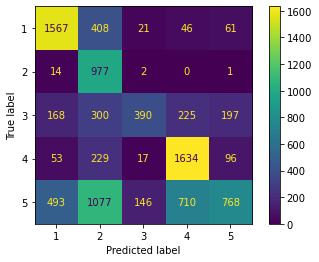

In [10]:
y_pred_tfidf_subsampling = tfidf_subsampling_model.predict(abstracts)
report_pipe_p1 = classification_report(Y_train, y_pred_tfidf_subsampling)
print("Test Report for Multinomial NB Pipe 1\n", report_pipe_p1)
cm1 = confusion_matrix(Y_train, y_pred_tfidf_subsampling)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels= tfidf_subsampling_model.classes_)
disp1.plot()

### Pipeline 2: Vectorización con TF-iDF y oversampling (+ reducción de dimensionalidad)

Usaremos TF-iDF también en este caso, pero en lugar de hacer undersampling, utilizaremos un algoritmo de oversampling. En este caso, utilizaremos una variación de SMOTE, denominada SMOTEENN para evitar generar muestras ruidosas [6]. Este algoritmo, en realidad, usa una mezcla de under y oversampling.

Finalmente, como aplicamos esta pipeline sobre los textos médicos (y no sobre las entidades extraídas), conviene hacer reducción de dimensionalidad. En este caso, utilizaremos PCA, que es una técnica de reducción de dimensionalidad lineal que se puede utilizar para extraer información de un espacio de alta dimensión proyectándola en un subespacio de menor dimensión. PCA Intenta preservar las partes esenciales que tienen más variación de los datos y eliminar las partes no esenciales con menos variación.

Mantendremos el 95% de la varianza de las componentes, lo que nos da una buena probabilidad de que los features elegidos no sean independientes de la variable objetivo. Así,

In [11]:
tfidf_oversampling_pipe = imbpipeline(steps = [
    ("tf_idf_vec",TfidfVectorizer()),
    ("sampling", SMOTEENN(random_state=28)),
    ('skb', SelectKBest(chi2)),
    ("algorithm", MultinomialNB())
])
tfidf_oversampling_pipe

Pipeline(steps=[('tf_idf_vec', TfidfVectorizer()),
                ('sampling', SMOTEENN(random_state=28)),
                ('skb',
                 SelectKBest(score_func=<function chi2 at 0x000001A6E7496A60>)),
                ('algorithm', MultinomialNB())])

In [12]:
tfidf_oversampling_model = GridSearchCV(estimator = tfidf_oversampling_pipe, 
                             param_grid = param_grid, 
                             cv=2, verbose=3,
                             scoring=custom_scorer)

In [13]:
tfidf_oversampling_model.fit(abstracts, Y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 1);, score=0.108 total time=   7.5s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 1);, score=0.122 total time=   7.5s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 2);, score=0.104 total time=  16.5s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 2);, score=0.150 total time=  16.6s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 3);, score=0.104 total time=  27.5s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, tf_idf_vec__ngram_range=(1, 3);, score=0.135 total time=  27.7s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=False, tf_idf_vec__ngram_range=(1, 1);, score=0.171 total time=   7.5s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fi

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tf_idf_vec', TfidfVectorizer()),
                                       ('sampling', SMOTEENN(random_state=28)),
                                       ('skb',
                                        SelectKBest(score_func=<function chi2 at 0x000001A6E7496A60>)),
                                       ('algorithm', MultinomialNB())]),
             param_grid={'algorithm__alpha': [0.05, 0.5, 1],
                         'algorithm__fit_prior': (True, False),
                         'tf_idf_vec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring=make_scorer(precision_score, average=micro), verbose=3)

In [14]:
#Para imprimir los mejores parametros:
tfidf_oversampling_model.best_params_

{'algorithm__alpha': 1,
 'algorithm__fit_prior': False,
 'tf_idf_vec__ngram_range': (1, 2)}

Test Report for Multinomial NB Pipe 2
               precision    recall  f1-score   support

           1       0.22      1.00      0.36      2103
           2       0.00      0.00      0.00       994
           3       0.00      0.00      0.00      1280
           4       0.00      0.00      0.00      2029
           5       0.75      0.00      0.00      3194

    accuracy                           0.22      9600
   macro avg       0.19      0.20      0.07      9600
weighted avg       0.30      0.22      0.08      9600



C:\Users\Alvaro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alvaro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alvaro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


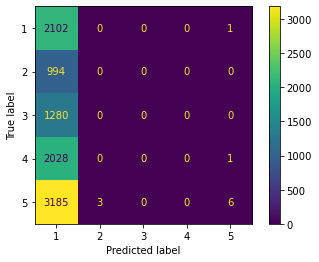

In [15]:
y_pred_tfidf_oversampling = tfidf_oversampling_model.predict(abstracts)
report_pipe_p2 = classification_report(Y_train, y_pred_tfidf_oversampling)
print("Test Report for Multinomial NB Pipe 2\n", report_pipe_p2)
cm2 = confusion_matrix(Y_train, y_pred_tfidf_oversampling)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels= tfidf_oversampling_model.classes_)
disp2.plot()

### Pipeline 3: Sin resampling, usando TF-iDF
El algoritmo de Naïve-Bayes, en particular, tiene una variante, denominada NBComplement() que nos permite lidiar con el problema de desbalance de clases sin necesidad de acudir a técnicas de resampling. Usamos PCA también para reducir un poco la dimensionalidad:

In [16]:
tf_idf_sin_oversampling = imbpipeline(steps = [
    ("tf_idf_vec",TfidfVectorizer()),
    ('skb', SelectKBest(chi2)),
    ("algorithm", ComplementNB())
])
tf_idf_sin_oversampling

Pipeline(steps=[('tf_idf_vec', TfidfVectorizer()),
                ('skb',
                 SelectKBest(score_func=<function chi2 at 0x000001A6E7496A60>)),
                ('algorithm', ComplementNB())])

In [17]:
param_grid2 = {"algorithm__alpha": [0.05, 0.5, 1],
              "algorithm__fit_prior": (True, False),
             "tf_idf_vec__ngram_range": [(1,1),(1,2),(1,3)],
              "algorithm__norm": (True, False)}

In [18]:
tf_idf_sin_oversampling_model = GridSearchCV(estimator = tf_idf_sin_oversampling, 
                             param_grid = param_grid2, 
                             cv=2, verbose=3,
                             scoring=custom_scorer)

In [19]:
tf_idf_sin_oversampling_model.fit(abstracts, Y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, algorithm__norm=True, tf_idf_vec__ngram_range=(1, 1);, score=0.334 total time=   2.5s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, algorithm__norm=True, tf_idf_vec__ngram_range=(1, 1);, score=0.330 total time=   2.6s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, algorithm__norm=True, tf_idf_vec__ngram_range=(1, 2);, score=0.333 total time=   8.5s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, algorithm__norm=True, tf_idf_vec__ngram_range=(1, 2);, score=0.326 total time=   7.9s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, algorithm__norm=True, tf_idf_vec__ngram_range=(1, 3);, score=0.333 total time=  16.2s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, algorithm__norm=True, tf_idf_vec__ngram_range=(1, 3);, score=0.326 total time=  16.5s
[CV 1/2] END algorithm__alpha=0.05, algorithm

[CV 2/2] END algorithm__alpha=1, algorithm__fit_prior=True, algorithm__norm=False, tf_idf_vec__ngram_range=(1, 1);, score=0.329 total time=   3.1s
[CV 1/2] END algorithm__alpha=1, algorithm__fit_prior=True, algorithm__norm=False, tf_idf_vec__ngram_range=(1, 2);, score=0.333 total time=   8.5s
[CV 2/2] END algorithm__alpha=1, algorithm__fit_prior=True, algorithm__norm=False, tf_idf_vec__ngram_range=(1, 2);, score=0.326 total time=   8.7s
[CV 1/2] END algorithm__alpha=1, algorithm__fit_prior=True, algorithm__norm=False, tf_idf_vec__ngram_range=(1, 3);, score=0.333 total time=  16.0s
[CV 2/2] END algorithm__alpha=1, algorithm__fit_prior=True, algorithm__norm=False, tf_idf_vec__ngram_range=(1, 3);, score=0.326 total time=  16.0s
[CV 1/2] END algorithm__alpha=1, algorithm__fit_prior=False, algorithm__norm=True, tf_idf_vec__ngram_range=(1, 1);, score=0.333 total time=   2.5s
[CV 2/2] END algorithm__alpha=1, algorithm__fit_prior=False, algorithm__norm=True, tf_idf_vec__ngram_range=(1, 1);, sc

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tf_idf_vec', TfidfVectorizer()),
                                       ('skb',
                                        SelectKBest(score_func=<function chi2 at 0x000001A6E7496A60>)),
                                       ('algorithm', ComplementNB())]),
             param_grid={'algorithm__alpha': [0.05, 0.5, 1],
                         'algorithm__fit_prior': (True, False),
                         'algorithm__norm': (True, False),
                         'tf_idf_vec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring=make_scorer(precision_score, average=micro), verbose=3)

In [20]:
#Para imprimir los mejores parametros:
tf_idf_sin_oversampling_model.best_params_

{'algorithm__alpha': 0.05,
 'algorithm__fit_prior': True,
 'algorithm__norm': True,
 'tf_idf_vec__ngram_range': (1, 1)}

Test Report for Multinomial NB Pipe 3
               precision    recall  f1-score   support

           1       0.26      0.98      0.42      2103
           2       0.47      0.12      0.19       994
           3       0.00      0.00      0.00      1280
           4       0.66      0.50      0.57      2029
           5       0.43      0.00      0.00      3194

    accuracy                           0.33      9600
   macro avg       0.36      0.32      0.23      9600
weighted avg       0.39      0.33      0.23      9600



C:\Users\Alvaro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alvaro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alvaro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


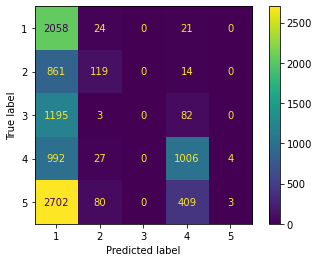

In [21]:
y_pred_tf_idf_sin_oversampling = tf_idf_sin_oversampling_model.predict(abstracts)
report_pipe_p3 = classification_report(Y_train, y_pred_tf_idf_sin_oversampling)
print("Test Report for Multinomial NB Pipe 3\n", report_pipe_p3)
cm3 = confusion_matrix(Y_train, y_pred_tf_idf_sin_oversampling)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels= tf_idf_sin_oversampling_model.classes_)
disp3.plot()

### Pipeline 4: Vectorización con Count-Vectorizer y subsampling.
Como dijimos previamente, usamos CountVectorizer puesto que en las entidades médicas las palabras importantes salen varias veces repetidas en el arreglo y queremos evitar reducir su importancia usando TF-iDF. En este caso, es necesario eliminar registros nulos, en caso de que los haya, si la librería no extrajo ninguna palabra relevante de alguna reseña en particular.

CountVectorizer es una herramienta proporcionada por la biblioteca scikit-learn en Python. Se utiliza para transformar un texto dado en un vector en función de la frecuencia (recuento) de cada palabra que aparece en todo el texto.

Usamos el mismo algoritmo de subsampling utilizado previamente:

In [22]:
def drop_na(df):
    return df[df['non_tokenized_entities'] != '']

datos_train_new = drop_na(datos_train)
entities = datos_train_new['tokenized_entities']
Y_train_new = datos_train_new['problems_described']

In [23]:
count_subsampling_pipe = imbpipeline(steps = [
    ("count_vec",CountVectorizer()),
    ("sampling", EditedNearestNeighbours()),
    ("algorithm", MultinomialNB())
])
count_subsampling_pipe

Pipeline(steps=[('count_vec', CountVectorizer()),
                ('sampling', EditedNearestNeighbours()),
                ('algorithm', MultinomialNB())])

In [24]:
param_grid = {"algorithm__alpha": [0.05, 0.5, 1],
              "algorithm__fit_prior": (True, False),
             "count_vec__ngram_range": [(1,1),(1,2),(1,3)]}

In [25]:
count_subsampling_model = GridSearchCV(estimator = count_subsampling_pipe, 
                             param_grid = param_grid, 
                             cv=2, verbose=3,
                             scoring=custom_scorer)

In [26]:
count_subsampling_model.fit(entities, Y_train_new)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 1);, score=0.491 total time=   0.9s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 1);, score=0.497 total time=   1.0s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 2);, score=0.490 total time=   1.7s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 2);, score=0.505 total time=   1.8s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 3);, score=0.477 total time=   2.8s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 3);, score=0.497 total time=   2.9s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=False, count_vec__ngram_range=(1, 1);, score=0.493 total time=   0.9s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('count_vec', CountVectorizer()),
                                       ('sampling', EditedNearestNeighbours()),
                                       ('algorithm', MultinomialNB())]),
             param_grid={'algorithm__alpha': [0.05, 0.5, 1],
                         'algorithm__fit_prior': (True, False),
                         'count_vec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring=make_scorer(precision_score, average=micro), verbose=3)

In [27]:
#Para imprimir los mejores parametros:
count_subsampling_model.best_params_

{'algorithm__alpha': 0.5,
 'algorithm__fit_prior': False,
 'count_vec__ngram_range': (1, 1)}

Test Report for Multinomial NB Pipe 4
               precision    recall  f1-score   support

           1       0.72      0.65      0.68      2103
           2       0.53      0.77      0.63       994
           3       0.41      0.60      0.49      1280
           4       0.67      0.73      0.70      2029
           5       0.55      0.37      0.44      3194

    accuracy                           0.58      9600
   macro avg       0.57      0.62      0.59      9600
weighted avg       0.59      0.58      0.57      9600



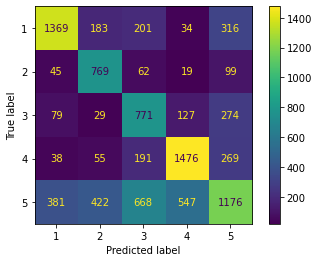

In [28]:
y_pred_count_subsampling = count_subsampling_model.predict(abstracts)
report_pipe_p4 = classification_report(Y_train, y_pred_count_subsampling)
print("Test Report for Multinomial NB Pipe 4\n", report_pipe_p4)
cm4 = confusion_matrix(Y_train, y_pred_count_subsampling)
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels= count_subsampling_model.classes_)
disp4.plot()

### Pipeline 5: Vectorización con Count-Vectorizer y oversampling.
Como dijimos previamente, usamos CountVectorizer puesto que en las entidades médicas las palabras importantes salen varias veces repetidas en el arreglo y queremos evitar reducir su importancia usando TF-iDF. Asimismo, intentamos de nuevo usar el SMOTE modificado, pero esta vez no hacemos PCA porque las palabras extraídas como entidades usando la librería entrenada sobre el corpus biomédico en el notebook anterior son relativamente pocas y hacer reducción de dimensionalidad puede alterar los resultados obtenidos:



In [29]:
count_oversampling_pipe = imbpipeline(steps = [
    ("count_vec", CountVectorizer()),
    ("sampling", SMOTEENN(random_state=28)),
    ("algorithm", MultinomialNB())
])
count_oversampling_pipe

Pipeline(steps=[('count_vec', CountVectorizer()),
                ('sampling', SMOTEENN(random_state=28)),
                ('algorithm', MultinomialNB())])

In [30]:
count_oversampling_model = GridSearchCV(estimator = count_oversampling_pipe, 
                             param_grid = param_grid, 
                             cv=2, verbose=3,
                             scoring=custom_scorer)

In [31]:
count_oversampling_model.fit(entities, Y_train_new)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 1);, score=0.518 total time=   2.3s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 1);, score=0.526 total time=   2.6s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 2);, score=0.509 total time=   3.2s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 2);, score=0.503 total time=   3.3s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 3);, score=0.495 total time=   5.0s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 3);, score=0.494 total time=   5.2s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=False, count_vec__ngram_range=(1, 1);, score=0.522 total time=   2.1s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('count_vec', CountVectorizer()),
                                       ('sampling', SMOTEENN(random_state=28)),
                                       ('algorithm', MultinomialNB())]),
             param_grid={'algorithm__alpha': [0.05, 0.5, 1],
                         'algorithm__fit_prior': (True, False),
                         'count_vec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring=make_scorer(precision_score, average=micro), verbose=3)

In [32]:
#Para imprimir los mejores parametros:
count_oversampling_model.best_params_

{'algorithm__alpha': 0.05,
 'algorithm__fit_prior': False,
 'count_vec__ngram_range': (1, 1)}

Test Report for Multinomial NB Pipe 5
               precision    recall  f1-score   support

           1       0.75      0.63      0.68      2103
           2       0.57      0.59      0.58       994
           3       0.51      0.37      0.43      1280
           4       0.69      0.64      0.67      2029
           5       0.47      0.58      0.52      3194

    accuracy                           0.58      9600
   macro avg       0.60      0.56      0.58      9600
weighted avg       0.59      0.58      0.58      9600



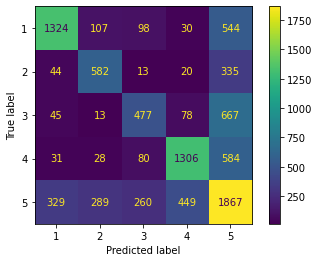

In [33]:
y_pred_count_oversampling = count_oversampling_model.predict(abstracts)
report_pipe_p5 = classification_report(Y_train, y_pred_count_oversampling)
print("Test Report for Multinomial NB Pipe 5\n", report_pipe_p5)
cm5 = confusion_matrix(Y_train, y_pred_count_oversampling)
disp5 = ConfusionMatrixDisplay(confusion_matrix=cm5, display_labels= count_oversampling_model.classes_)
disp5.plot()

### Pipeline 6: Sin resampling, usando Count-Vectorizer
Usamos ComplementNB():

In [34]:
count_sin_oversampling = imbpipeline(steps = [
    ("count_vec",CountVectorizer()),
    ("algorithm", ComplementNB())
])
count_sin_oversampling

Pipeline(steps=[('count_vec', CountVectorizer()),
                ('algorithm', ComplementNB())])

In [35]:
count_sin_oversampling_model = GridSearchCV(estimator = count_sin_oversampling, 
                             param_grid = param_grid, 
                             cv=2, verbose=3,
                             scoring=custom_scorer)

In [36]:
count_sin_oversampling_model.fit(entities, Y_train_new)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 1);, score=0.510 total time=   0.4s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 1);, score=0.516 total time=   0.4s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 2);, score=0.489 total time=   1.2s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 2);, score=0.500 total time=   1.2s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 3);, score=0.482 total time=   2.4s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior=True, count_vec__ngram_range=(1, 3);, score=0.495 total time=   2.3s
[CV 1/2] END algorithm__alpha=0.05, algorithm__fit_prior=False, count_vec__ngram_range=(1, 1);, score=0.510 total time=   0.4s
[CV 2/2] END algorithm__alpha=0.05, algorithm__fit_prior

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('count_vec', CountVectorizer()),
                                       ('algorithm', ComplementNB())]),
             param_grid={'algorithm__alpha': [0.05, 0.5, 1],
                         'algorithm__fit_prior': (True, False),
                         'count_vec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring=make_scorer(precision_score, average=micro), verbose=3)

In [37]:
#Para imprimir los mejores parametros:
count_sin_oversampling_model.best_params_

{'algorithm__alpha': 1,
 'algorithm__fit_prior': True,
 'count_vec__ngram_range': (1, 1)}

Test Report for Multinomial NB Pipe 6
               precision    recall  f1-score   support

           1       0.71      0.86      0.78      2103
           2       0.63      0.73      0.67       994
           3       0.61      0.61      0.61      1280
           4       0.61      0.89      0.73      2029
           5       0.77      0.41      0.54      3194

    accuracy                           0.67      9600
   macro avg       0.67      0.70      0.66      9600
weighted avg       0.69      0.67      0.65      9600



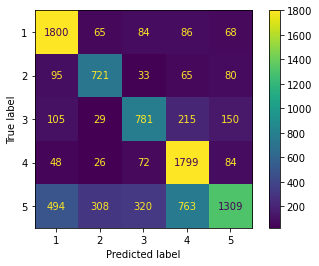

In [39]:
y_pred_count_sin_oversampling = count_sin_oversampling_model.predict(abstracts)
report_pipe_p6 = classification_report(Y_train, y_pred_count_sin_oversampling)
print("Test Report for Multinomial NB Pipe 6\n", report_pipe_p6)
cm6 = confusion_matrix(Y_train, y_pred_count_sin_oversampling)
disp6 = ConfusionMatrixDisplay(confusion_matrix=cm6, display_labels= count_sin_oversampling_model.classes_)
disp6.plot()

# Conclusión

De todos los modelos generados, elegiremos el modelo creado en el Pipeline 6 (sin resampling y usando Count-Vectorizer), pues es el que tiene los mejores resultados para las métricas de presición y recall. Procedemos a exportar este modelo para utilizarlo en el notebook de la etapa de validación.

In [46]:
file = open("multinomial_nb.joblib","wb")
joblib.dump(count_sin_oversampling_model,file)
file.close()